### Cardiovascular disease risk prediction among women

In [20]:
#Importing modules
import pysurvival
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pysurvival
from pysurvival.datasets import Dataset
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [21]:
import torch
import random
import numpy as np
import os
def seed_everything(seed=42):
 """"
 Seed everything.
 """ 
 random.seed(seed)
 os.environ['PYTHONHASHSEED'] = str(seed)
 np.random.seed(seed)
 torch.manual_seed(seed)
 torch.cuda.manual_seed(seed)
 torch.cuda.manual_seed_all(seed)
 torch.backends.cudnn.deterministic = True
SEED = 12345678 #random.randint(0,100000)
print(SEED)
seed_everything(SEED)

12345678


In [22]:
###importing important libraries
####Models
from pysurvival.models.semi_parametric import CoxPHModel #cox proportional hazard
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
from pysurvival.models.multi_task import LinearMultiTaskModel  #Linear Multi Task logistic regression Models
from pysurvival.models.multi_task import NeuralMultiTaskModel #Neural -Multitask Logistic Regression
from pysurvival.models.semi_parametric import NonLinearCoxPHModel  ##NonLinear CoxPH model(DeepSurv)
from pysurvival.models.svm import LinearSVMModel
from pysurvival.models.svm import KernelSVMModel
###evaluation metrics
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import compare_to_actual
### ReaptedKF
from sklearn.model_selection import RepeatedKFold

In [23]:
def evaluate(model, X, T, E, model_name=""):
    errors=compare_to_actual(model, X, T, E, is_at_risk=True)
    c_index=concordance_index(model, X, T, E)
    ibs=integrated_brier_score(model, X, T, E)
    metrics={'c-index': c_index, 'IBS':ibs}
    eval_df=pd.DataFrame(data={**metrics, **errors}, index=[model_name])
    return eval_df.rename(columns={'root_mean_squared_error':'RMSE',
                                   'median_absolute_error':'MADE',
                                    'mean_absolute_error': 'MAE'})

In [24]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [25]:
dtafile='A:/Objective 3/Replication_Jo_paper/Johannes_Imputed_Women.dta'
dJh=pd.read_stata(dtafile)
dJh.head(5)

,BL_HDL_mmolL,BL_TC_mmolL,BL_Cr_mgDL,AgeAtRand,BL_SBP_Mean,bl_antihyp,Diab_deriv,BL_SmHis,MACE,MACE_DSR,non_HDL_C,fyear,Smoking
0,1.5,6.4,1.000000,86.08,145.0,1,0,3,0,3089.0,4.9,8.457221,0
1,1.2,6.6,1.000000,72.93,127.0,1,0,3,0,3564.0,5.4,9.757700,0
2,1.8,6.4,0.800000,85.48,177.0,0,0,3,0,812.0,4.6,2.223135,0
3,1.1,3.8,0.885861,71.59,127.0,1,1,3,0,3458.0,2.7,9.467488,0
4,2.9,5.5,0.800000,72.02,139.0,1,0,3,0,2223.0,2.6,6.086242,0


In [26]:
dJh.rename(columns={'BL_HDL_mmolL': 'HDL_Cholesterol', 'BL_Cr_mgDL':'Serum creatinine', 'AgeAtRand': 'Age', 
                   'BL_SBP_Mean':'Systolic blood pressure', 'bl_antihyp': 'Antihypertensive medication use', 'Diab_deriv': 'Diabetes', 'non_HDL_C': 'Non_HDL_cholesterol'}, inplace=True)

In [27]:
dJh_Final=dJh[['Age', 'HDL_Cholesterol', 'Serum creatinine', 'Systolic blood pressure', "Antihypertensive medication use",
           'Diabetes', 'Non_HDL_cholesterol', 'Smoking', 'MACE', 'fyear']]

In [28]:
time_column='fyear'
event_column='MACE'
features_full= np.setdiff1d(dJh_Final.columns, [time_column, event_column]).tolist()

In [29]:
N_null=sum(dJh_Final[features_full].isnull().sum())
print("the dataset contains {} null values".format(N_null))
N=dJh_Final.shape[0]

the dataset contains 0 null values


In [30]:
from sklearn.model_selection import train_test_split
index_train, index_test=train_test_split(range(N), test_size=0.3, random_state=SEED)
data_train=dJh_Final.loc[index_train].reset_index(drop=True)
data_test=dJh_Final.loc[index_test].reset_index(drop=True)
###creating the X, T, and E inputs
X_train, X_test=data_train[features_full], data_test[features_full]
T_train, T_test=data_train[time_column], data_test[time_column]
E_train, E_test=data_train[event_column], data_test[event_column]

## Model traing and evaluation 

### CoxPH Model

In [31]:
# Initializing the CoxPH model
import numpy as np
np.random.seed(12345678)
Cox = CoxPHModel()
# Fitting the model
Cox.fit(X_train, T_train, E_train, verbose=False)

CoxPHModel

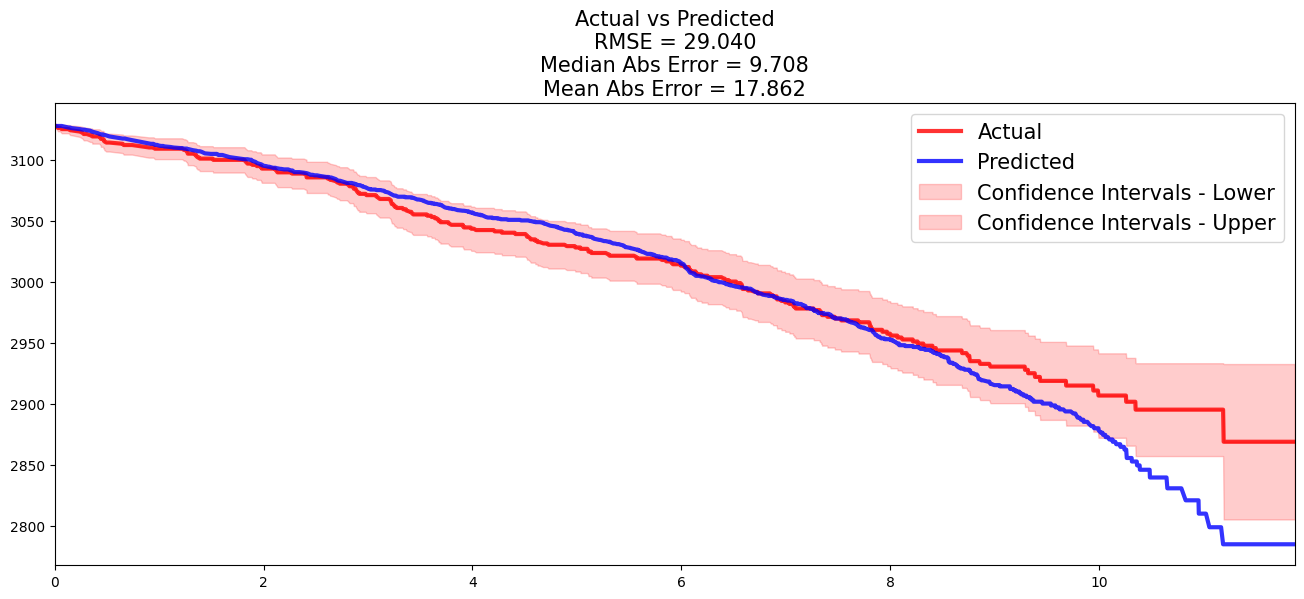

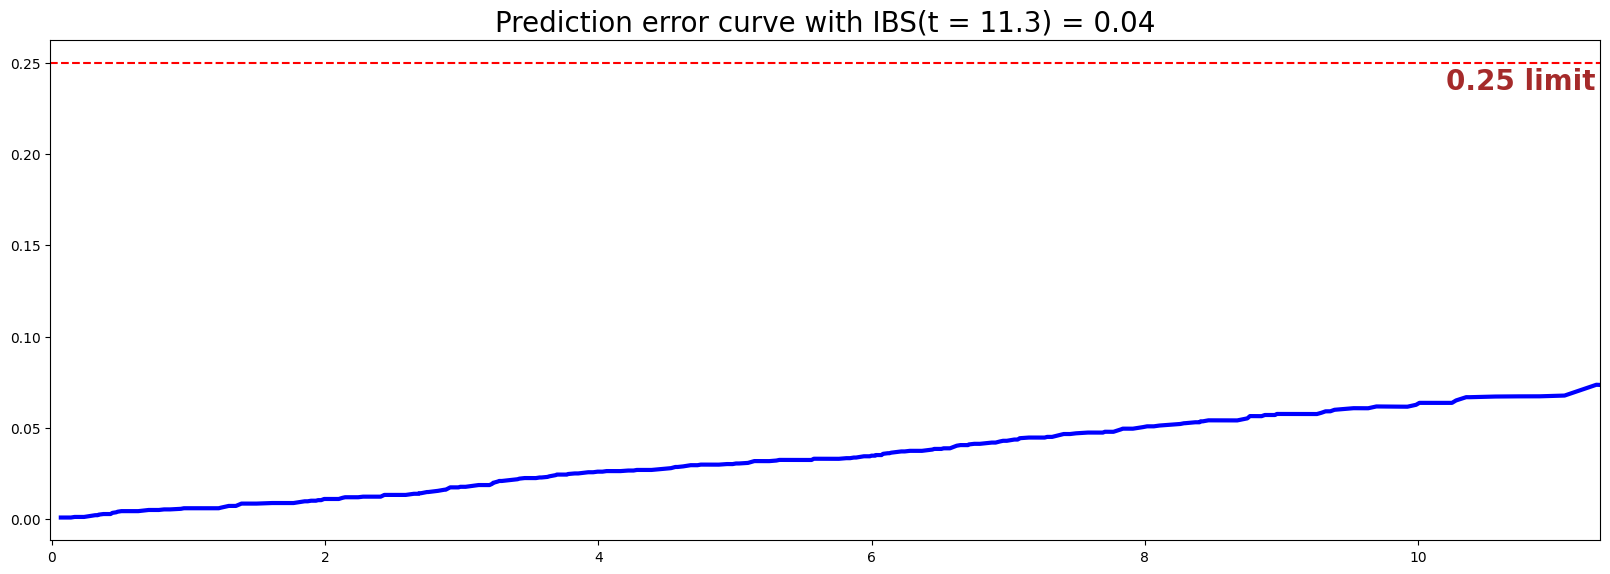

,c-index,IBS,RMSE,MADE,MAE
Cox,0.701753,0.035075,29.039518,9.708487,17.862


In [14]:
###IBS
eval_Cox=evaluate(Cox, X_test, T_test, E_test, model_name ="Cox")
eval_Cox

### RSF

In [32]:
###Random survival forest
RSF=RandomSurvivalForestModel()
RSF.fit(X_train, T_train, E_train)

RandomSurvivalForestModel

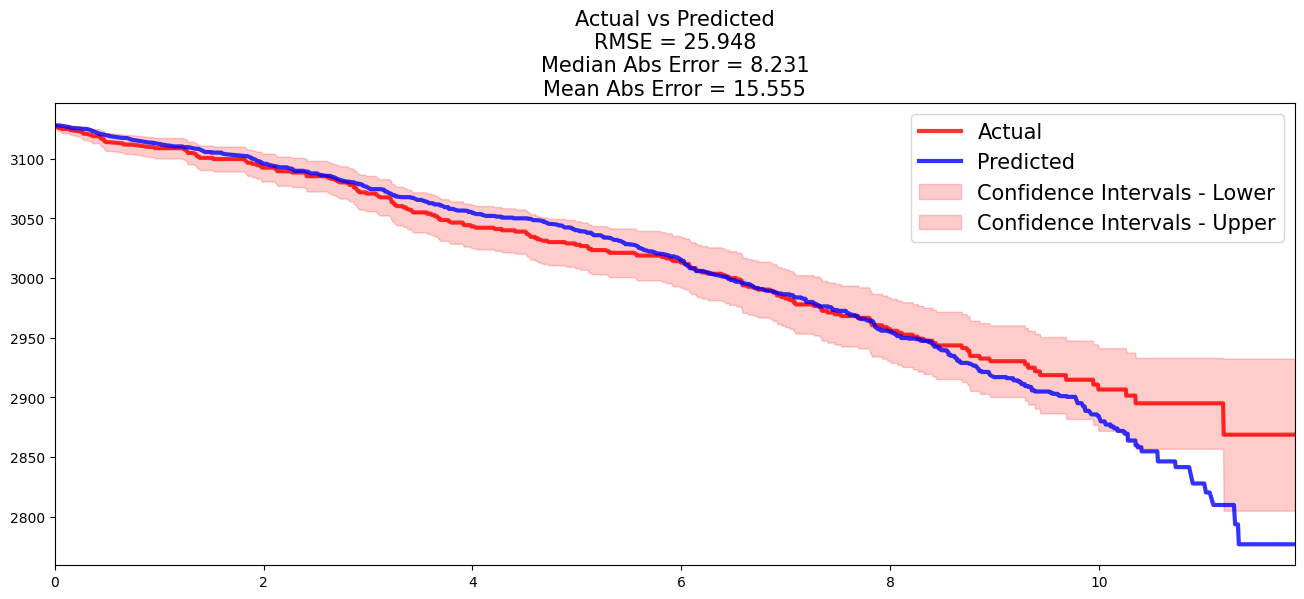

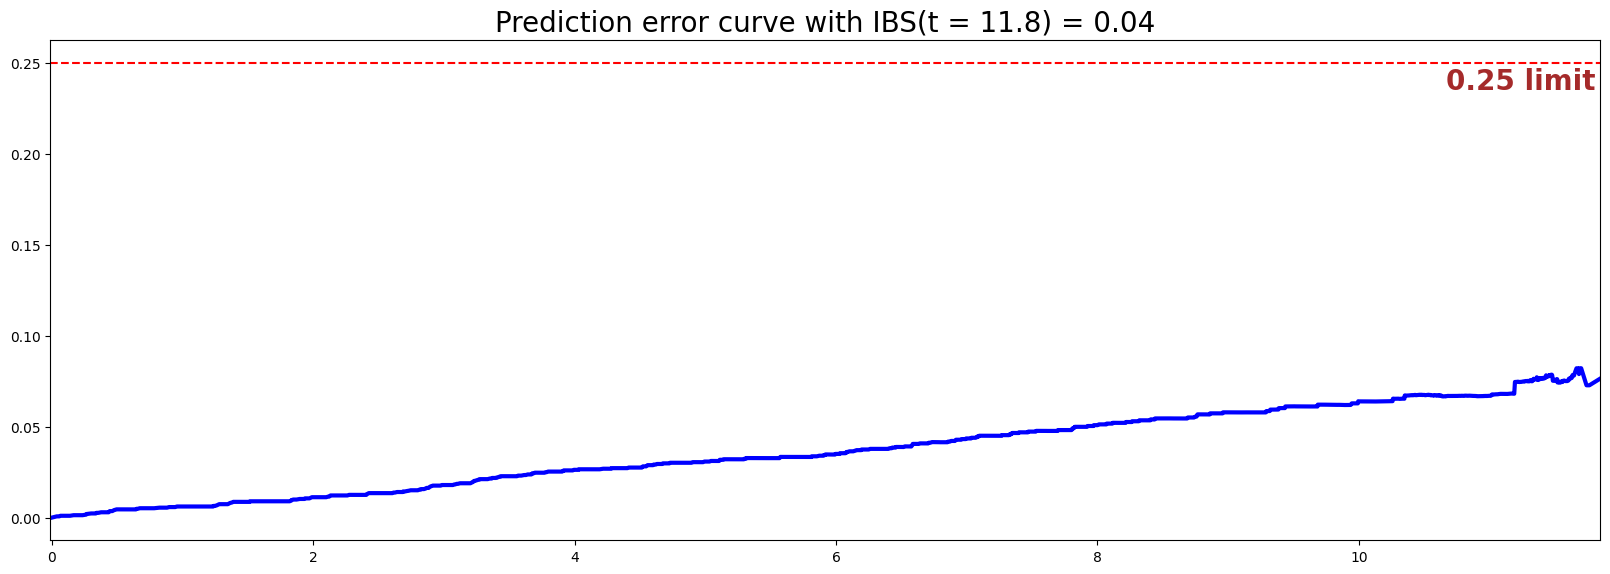

,c-index,IBS,RMSE,MADE,MAE
RSF,0.66077,0.036983,25.947971,8.230538,15.555156


In [17]:
eval_RSF=evaluate(RSF, X_test, T_test, E_test, model_name ="RSF")
eval_RSF

### NMTLR

In [33]:
###Neural multitask logistic regression 
# Initializing the Neural MTLR with a time axis split into
structure = [ 
                {'activation': 'LogSigmoid', 'num_units': 73}, 
                {'activation': 'Atan', 'num_units': 14},
                {'activation': 'Softsign', 'num_units': 44},
                {'activation': 'Swish', 'num_units': 49},
                {'activation': 'InverseSqrt', 'num_units': 25}   
            ] 
Neural_MTLR = NeuralMultiTaskModel(bins=46, structure=structure)

In [34]:
# Fitting the model
Neural_MTLR.fit(X_train, T_train, E_train,
                optimizer ='rmsprop', lr = 0.00083, num_epochs=693,
                dropout = 0.4, l2_reg = 0.0078, l2_smooth = 0.004,
                batch_normalization = False
                )

% Completion: 100%|**********************************************|Loss: 3064.81


NeuralMultiTaskModel( Layer(1): activation = LogSigmoid, units = 73 ; 
                      Layer(2): activation = Atan, units = 14 ; 
                      Layer(3): activation = Softsign, units = 44 ; 
                      Layer(4): activation = Swish, units = 49 ; 
                      Layer(5): activation = InverseSqrt, units = 25 )

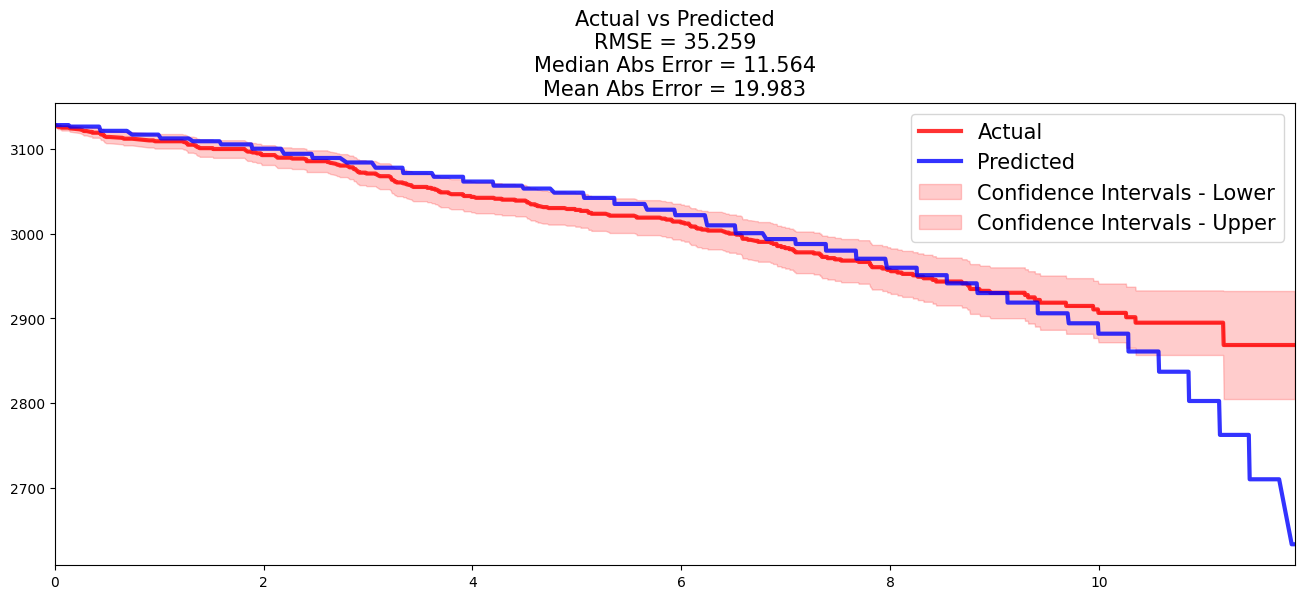

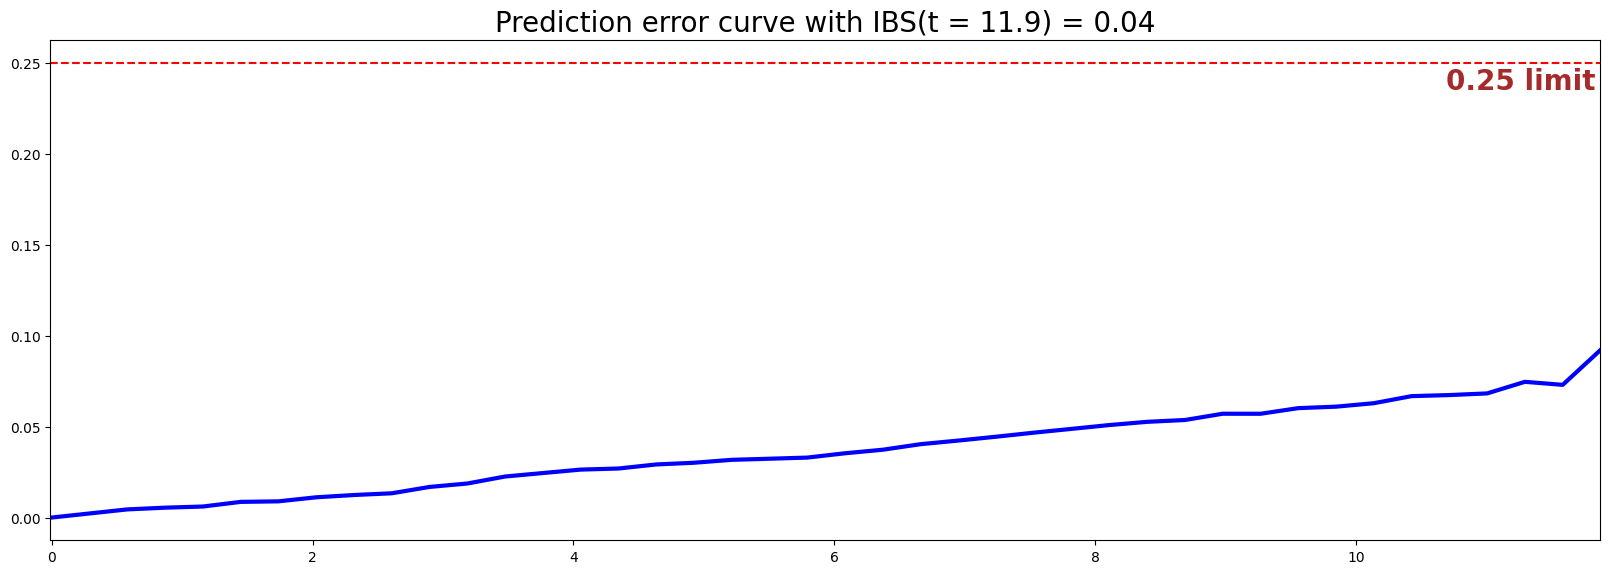

,c-index,IBS,RMSE,MADE,MAE
Neural_MTLR,0.72323,0.036824,35.25926,11.564317,19.983184


In [21]:
###IBS
eval_Neural_MTLR=evaluate(Neural_MTLR, X_test, T_test, E_test, model_name ="Neural_MTLR")
eval_Neural_MTLR

### DeepSurv

In [35]:
###DeepSurv
structure1=[{'activation': 'BipolarSigmoid', 'num_units': 13},
           {'activation': 'BipolarSigmoid', 'num_units': 12},
           {'activation': 'Swish', 'num_units': 66},
           {'activation': 'LeCunTanh', 'num_units': 68}
           ]
DeepSurv = NonLinearCoxPHModel(structure=structure1)

In [36]:
# Fitting the model
DeepSurv.fit(X_train, T_train, E_train,
                optimizer = 'sgd', lr = 0.00037, num_epochs=1500,
                dropout = 0.3, l2_reg = 0.0062,
                batch_normalization = False
            )

% Completion: 100%|**********************************************|Loss: 3726.98


NonLinearCoxPHModel( Layer(1): activation = BipolarSigmoid, num_units = 13 ; 
                     Layer(2): activation = BipolarSigmoid, num_units = 12 ; 
                     Layer(3): activation = Swish, num_units = 66 ; 
                     Layer(4): activation = LeCunTanh, num_units = 68 )

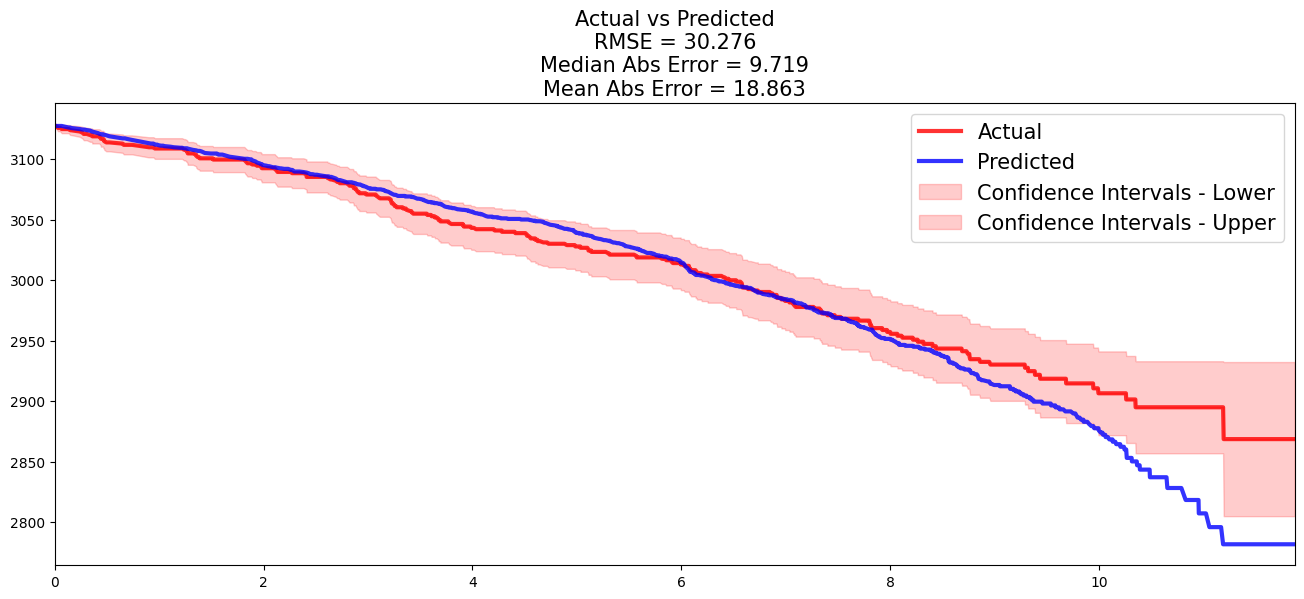

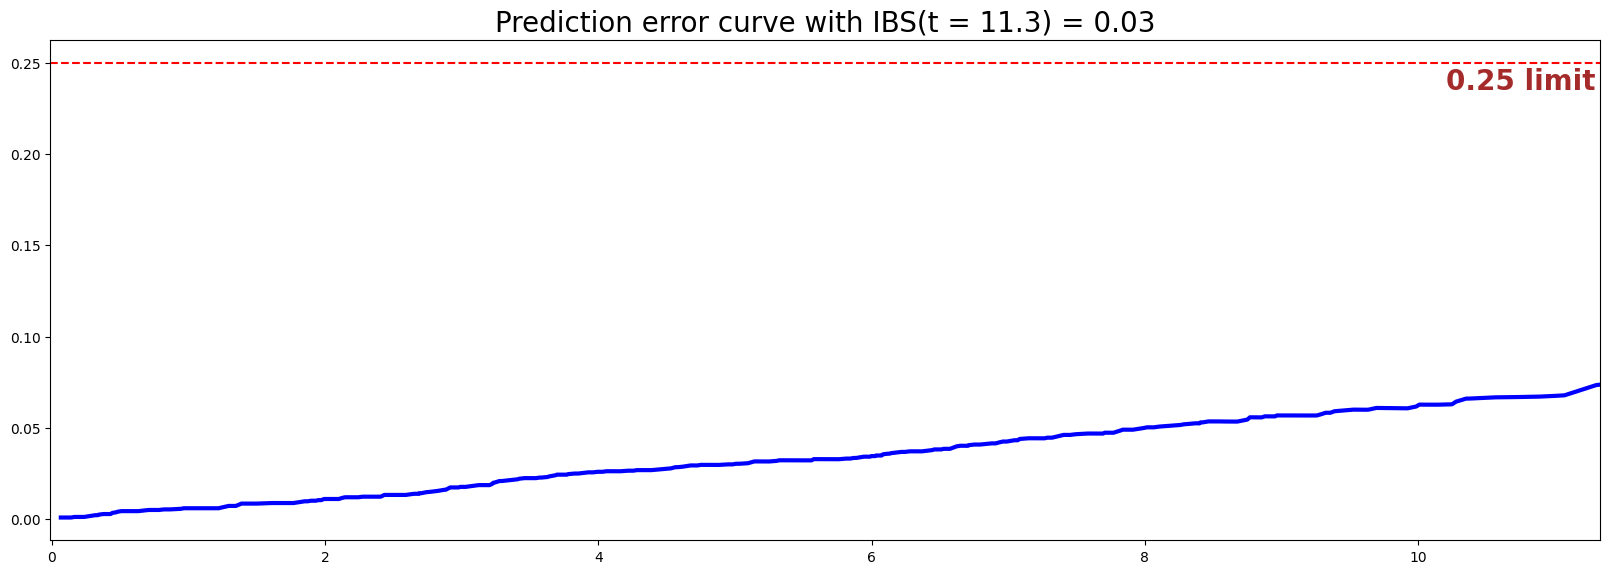

,c-index,IBS,RMSE,MADE,MAE
DeepSurv,0.727873,0.034796,30.275612,9.718637,18.862603


In [25]:
###IBS
eval_DeepSurv=evaluate(DeepSurv, X_test, T_test, E_test, model_name ="DeepSurv")
eval_DeepSurv

In [26]:
eval_all=pd.concat([eval_Cox,eval_RSF, eval_Neural_MTLR, eval_DeepSurv])
eval_all

,c-index,IBS,RMSE,MADE,MAE
Cox,0.701753,0.035075,29.039518,9.708487,17.862000
RSF,0.660770,0.036983,25.947971,8.230538,15.555156
Neural_MTLR,0.723230,0.036824,35.259260,11.564317,19.983184
DeepSurv,0.727873,0.034796,30.275612,9.718637,18.862603


In [27]:
## Bootstrap method to comapre the c-index 
from sklearn.utils import resample
def bootstrap_c_index(model,X, T, E, n_bootstrap=1000):
    c_indices = []
    for _ in range(n_bootstrap):
        #generate bootstrap sample
        X_boot, T_boot, E_boot = resample(X, T, E)
        
          #Calculate C-index for this sample
        c_index = concordance_index(model,X_boot, T_boot, E_boot)
        c_indices.append(c_index)
    return np.array(c_indices)

In [28]:
## The data was splited into training and testing and All the four models were trained 
#Calculate bootstarp C-index distribution 
Cox_c_indices = bootstrap_c_index(Cox, X_test, T_test, E_test)
rsf_c_indices = bootstrap_c_index(RSF, X_test, T_test, E_test)
NMTLR_c_indices = bootstrap_c_index(Neural_MTLR, X_test, T_test, E_test)
DeepSurv_c_indices = bootstrap_c_index(DeepSurv, X_test, T_test, E_test)

In [29]:
#calculate mean c-index and CI
def summarize_c_index(c_indices):
    mean = np.mean(c_indices)
    ci = np.percentile(c_indices, [2.5, 97.5])
    return mean, ci

cox_mean, cox_ci = summarize_c_index(Cox_c_indices)
rsf_mean, rsf_ci = summarize_c_index(rsf_c_indices)
NMTLR_mean, NMTLR_ci = summarize_c_index(NMTLR_c_indices)
DeepSurv_mean, DeepSurv_ci = summarize_c_index(DeepSurv_c_indices)

print(f"Cox C-index: {cox_mean: .3f} (95%CI: {cox_ci[0]: .3f}-{cox_ci[1]: .3f})")
print(f"RSF C-index: {rsf_mean: .3f} (95%CI: {rsf_ci[0]: .3f}-{rsf_ci[1]: .3f})")
print(f"NMTLR C-index: {NMTLR_mean: .3f} (95%CI: {NMTLR_ci[0]: .3f}-{NMTLR_ci[1]: .3f})")
print(f"DeepSurv C-index: {DeepSurv_mean: .3f} (95%CI: {DeepSurv_ci[0]: .3f}-{DeepSurv_ci[1]: .3f})")

Cox C-index:  0.699 (95%CI:  0.642- 0.758)
RSF C-index:  0.660 (95%CI:  0.602- 0.717)
NMTLR C-index:  0.721 (95%CI:  0.665- 0.777)
DeepSurv C-index:  0.726 (95%CI:  0.669- 0.780)


In [30]:
# perform pairwise comparisions
from scipy import stats
def compare_c_indices(c_indices1, c_indices2):
    t_stat, p_value = stats.ttest_rel(c_indices1, c_indices2)
    return p_value
p_cox_rsf = compare_c_indices(Cox_c_indices, rsf_c_indices)
p_cox_NMTLR = compare_c_indices(Cox_c_indices, NMTLR_c_indices)
p_cox_DeepSurv = compare_c_indices(Cox_c_indices, DeepSurv_c_indices)
p_rsf_NMTLR= compare_c_indices(rsf_c_indices, NMTLR_c_indices)
p_rsf_DeepSurv = compare_c_indices(rsf_c_indices, DeepSurv_c_indices)
p_NMTLR_DeepSurv = compare_c_indices(NMTLR_c_indices, DeepSurv_c_indices)
print(f"Cox vs RSF p-value: {p_cox_rsf: .3f}")
print(f"Cox vs NMTLR p-value: {p_cox_NMTLR: .3f}")
print(f"Cox vs DeepSurv p-value: {p_cox_DeepSurv: .3f}")
print(f"RSF vs NMTLR p-value: {p_rsf_NMTLR: .3f}")
print(f"RSF vs DeepSurv p-value: {p_rsf_DeepSurv: .3f}")
print(f"NMTLR vs DeepSurv p-value: {p_NMTLR_DeepSurv: .3f}")

Cox vs RSF p-value:  0.000
Cox vs NMTLR p-value:  0.000
Cox vs DeepSurv p-value:  0.000
RSF vs NMTLR p-value:  0.000
RSF vs DeepSurv p-value:  0.000
NMTLR vs DeepSurv p-value:  0.000


### Variable importance

In [37]:
### Feature importance plot
for col in X_train:
 print(col)
X_train.columns

Age
Antihypertensive medication use
Diabetes
HDL_Cholesterol
Non_HDL_cholesterol
Serum creatinine
Smoking
Systolic blood pressure


Index(['Age', 'Antihypertensive medication use', 'Diabetes', 'HDL_Cholesterol',
       'Non_HDL_cholesterol', 'Serum creatinine', 'Smoking',
       'Systolic blood pressure'],
      dtype='object')

In [38]:
####
def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2)/ctmp)
    return imps

In [39]:
imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(DeepSurv, X_test, T_test, E_test),
        'NMTLR': variableImportance(Neural_MTLR, X_test, T_test, E_test),
        'RSF': variableImportance(RSF, X_test, T_test, E_test),
    },
    index= X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)

                                 DeepSurv     NMTLR       RSF   Average
Age                              0.179635  0.239719  0.218121  0.212492
Antihypertensive medication use  0.015661 -0.002256  0.028361  0.013922
Diabetes                        -0.004083 -0.008773  0.006450 -0.002135
HDL_Cholesterol                  0.007116  0.013688  0.002561  0.007788
Non_HDL_cholesterol              0.026220  0.015089 -0.007210  0.011367
Serum creatinine                -0.003457 -0.000522  0.009712  0.001911
Smoking                          0.014007  0.014735  0.013302  0.014015
Systolic blood pressure          0.004476 -0.008900 -0.009584 -0.004669


C:\Users\ates0004\AppData\Local\Temp\2\ipykernel_9280\3413440512.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=truncate_colormap(cm.get_cmap("Spectral"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-4))


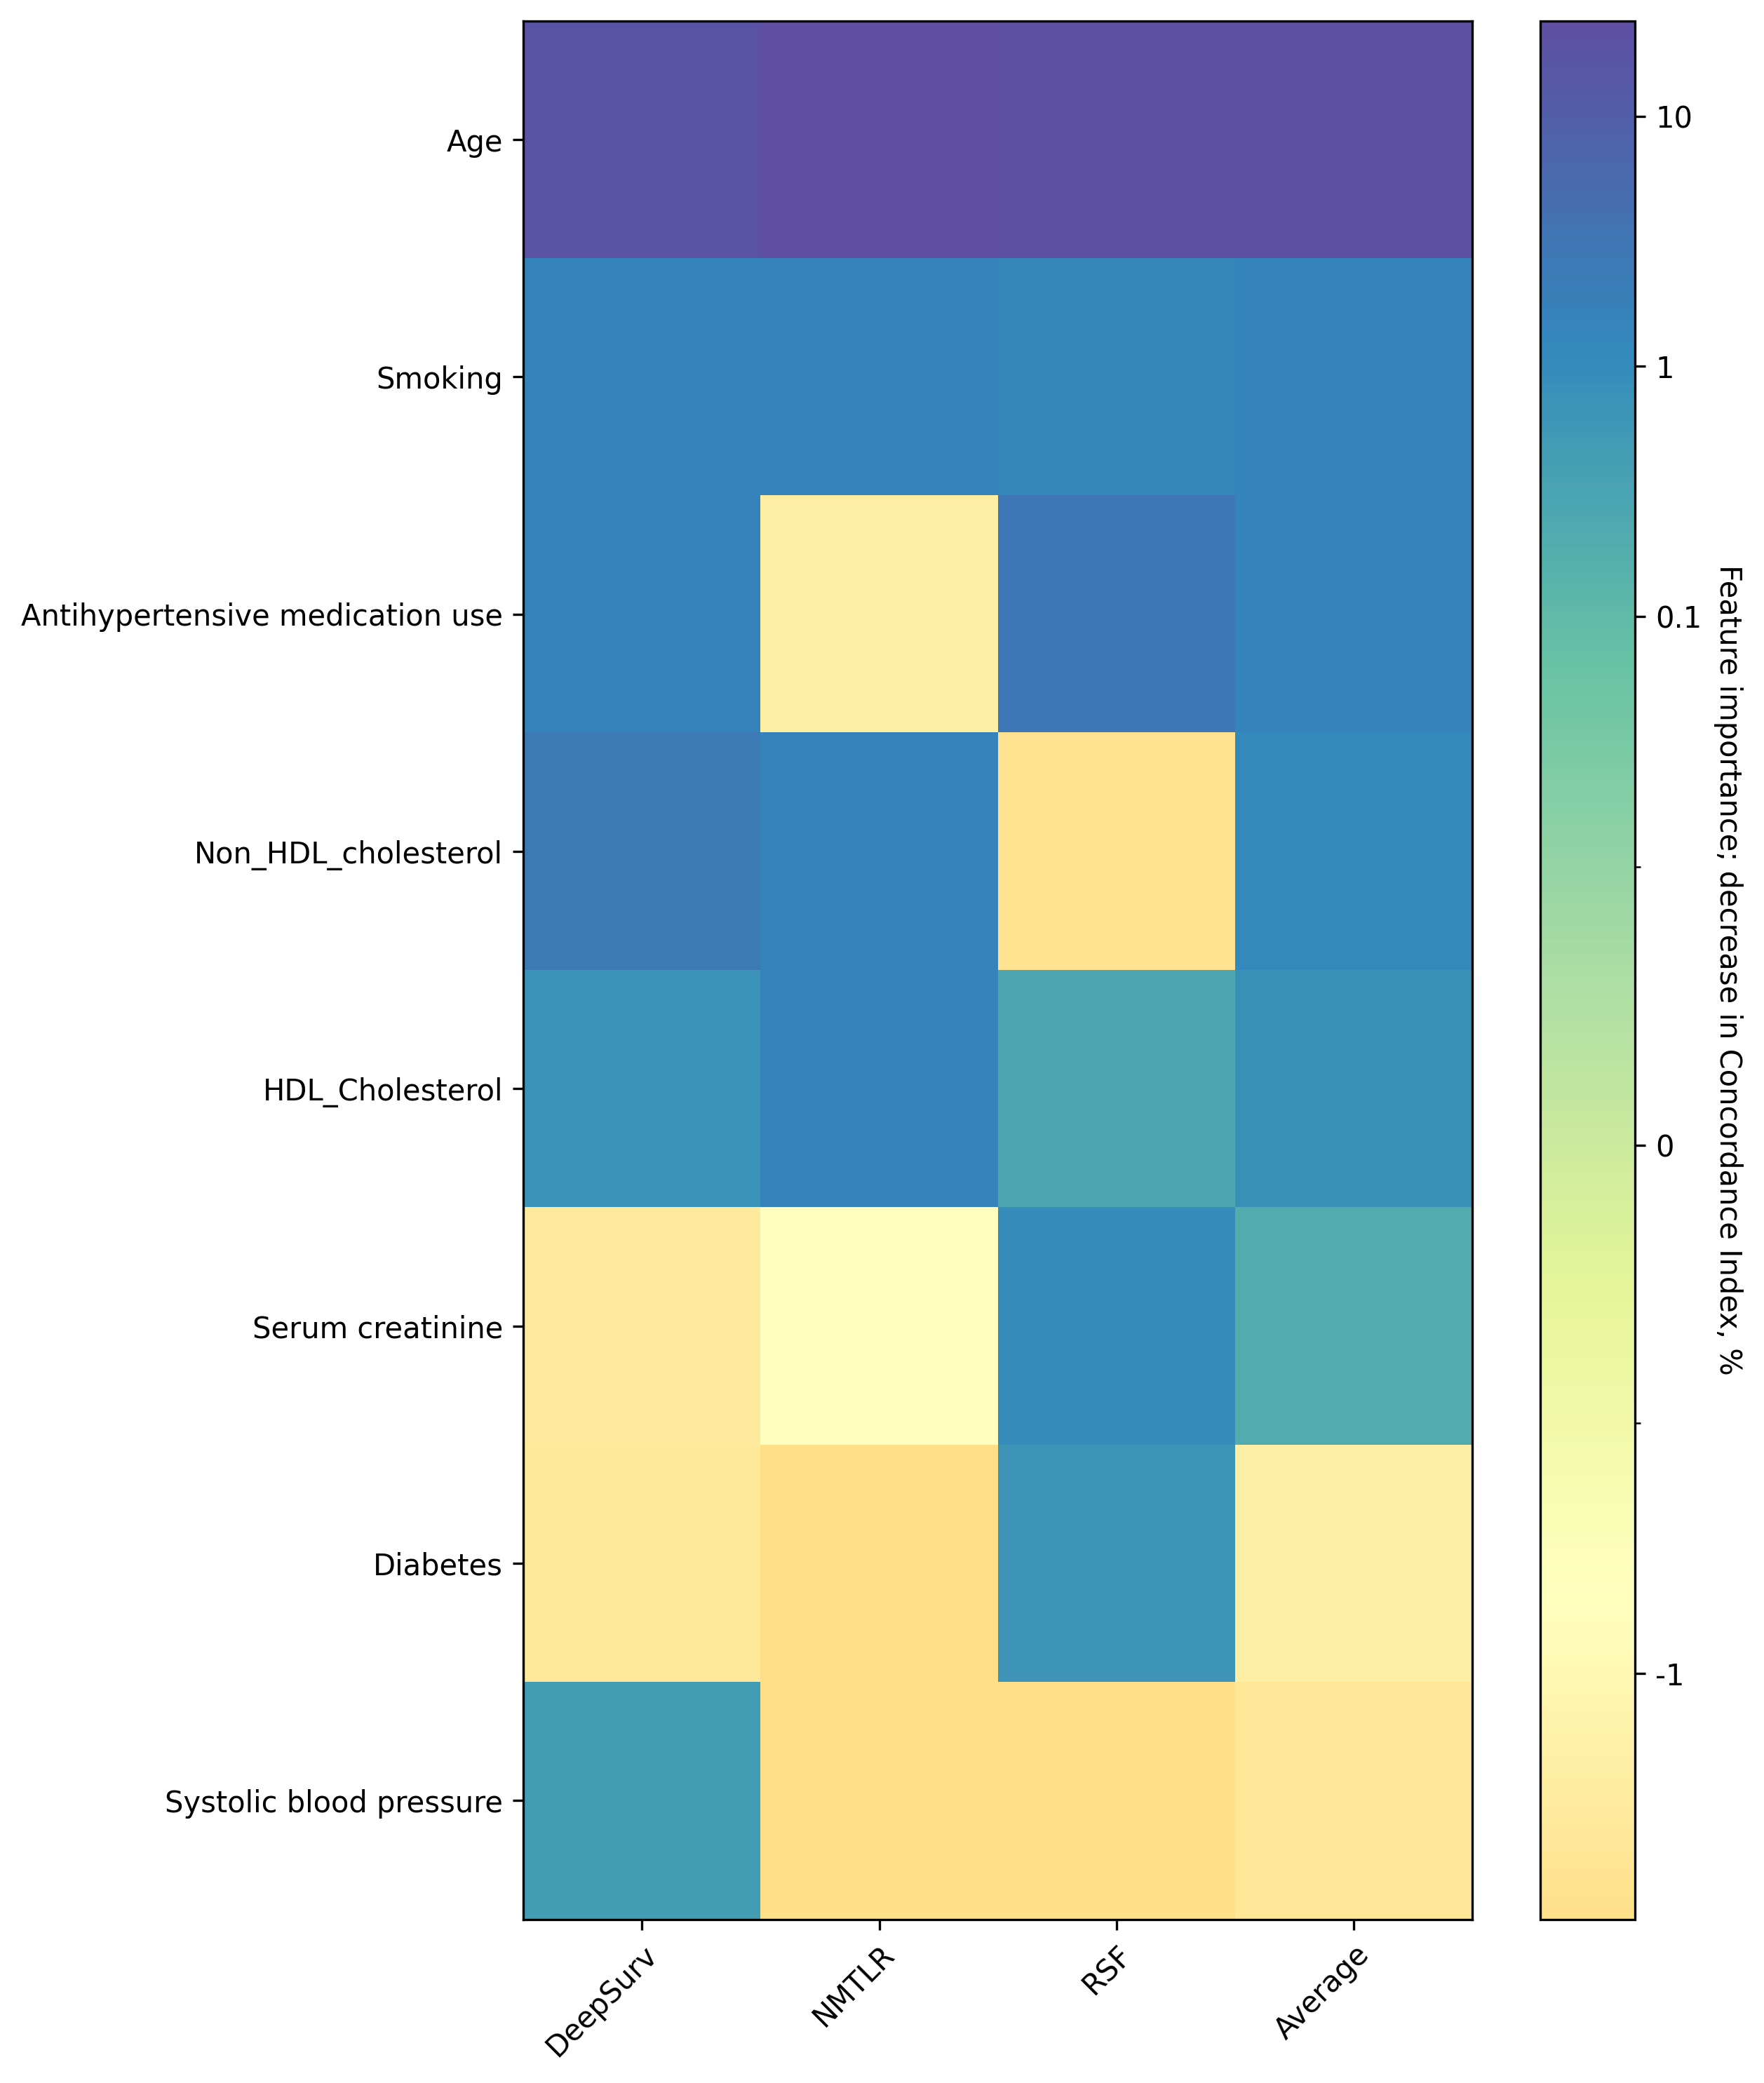

In [40]:
def plotFeatureImportance(a):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    mpl.rcParams['figure.dpi'] = 300
    # a = pd.read_csv(feature_filename)
    a = a.sort_values(by=['Average'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 10))
    
    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap
    
    im = ax.imshow(a[['DeepSurv', 'NMTLR', 'RSF', 'Average']],
                   cmap=truncate_colormap(cm.get_cmap("Spectral"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-4))
                    # im.set_clim(-5, -2)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Feature importance; decrease in Concordance Index, %", rotation=-90, va="bottom")
    # cbar.ax.set_aspect(50)
    cbar.set_ticks([0.1,0.01,0.001,0,-0.001])
    cbar.set_ticklabels(['10',"1","0.1",0,'-1'])
    
    ax.set_yticks(np.arange(len(a)))
    ax.set_xticks(np.arange(len(a.columns)))
    ax.set_xticklabels(['DeepSurv', 'NMTLR', 'RSF', 'Average'])
    ax.set_yticklabels(a.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig("A:\Objective 3\Replication_Jo_paper\DCA\wVIP")
    plt.show()
plotFeatureImportance(imp_df)

### Risk score

### Cox PH

In [41]:
###Risk score
best_model=Cox
risk_profile_Coxw=X_test.copy()
risk_profile_Coxw['risk_score']=best_model.predict_risk(risk_profile_Coxw, use_log=False)

### RSF

In [42]:
###Risk score
best_model=RSF
risk_profile_RSFw=X_test.copy()
risk_profile_RSFw['risk_score']=best_model.predict_risk(risk_profile_RSFw, use_log=False)

### NMTLR

In [43]:
###Risk score
best_model=Neural_MTLR
risk_profile_NMTLRw=X_test.copy()
risk_profile_NMTLRw['risk_score']=best_model.predict_risk(risk_profile_NMTLRw, use_log=False)

### DeepSurv

In [44]:
###Risk score
best_model=DeepSurv
risk_profile_DeepSurvw=X_test.copy()
risk_profile_DeepSurvw['risk_score']=best_model.predict_risk(risk_profile_DeepSurvw, use_log=False)

### Saving models

In [45]:
import pickle
##Deepsurv
filename = 'DeepSurv_Jo_women.pkl'
with open(filename, 'wb') as file:
    pickle.dump(DeepSurv, file)

pickle_inDw=open('DeepSurv_Jo_women.pkl', 'rb')
DeepSurv = pickle.load (pickle_inDw)

In [47]:
#NMTLR
filename = 'NMTLR_Jo_women.pkl'
with open(filename, 'wb') as file:
    pickle.dump(Neural_MTLR, file)

pickle_inNw=open('NMTLR_Jo_women.pkl', 'rb')
NMTLR = pickle.load (pickle_inNw)